In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import joblib
import math

# Read data and calculate ratios

In [145]:
nCluster=8
df = pd.read_pickle("data/dataframe")
yearsString = ["14", "15", "16", "17", "18", "19", "20"]
arbevetel = ["TAH197"]
koltseg = ["TAC008",
"TAC009","TAC011","TAC010","TAC078","TAH014","TAH015","TAC012","TAC013","TAC014","TAC015","TAC016","TAC018","TAC063","TAH021","TAC109","TAC190","TAC059","TAB024","TAH197"]
merlegfoosszeg=["TAH186",
"TAH230","TAH033","TAH087","TAH088","TAH041","TAH042","TAH231","TAH043","TAH044","TAH232","TAH045", "TAH187", "TAI001",
"TAI002","TAI019","TAI020","TAI022","TAI023","TAI041","TAI042","TAI043","TAI044","TAI033","TAH034","TAI045","TAI046","TAI035","TAI047","TAI048","TAI036","TAI049","TAI050","TAI037","TAI051","TAI052","TAI053","TAI054","TAI055","TAI056","TAI057","TAH190","TAI038","TAI058", "TAB024","TAH197"]
liabilities = ["TAH209","TAH051","TAH227","TAH054","TAH055","TAH180","TAH199"]
toke = ["TAH002","TAH003","TAH004","TAH005","TAH011","TAH007","TAH233","TAH234","TAH012","TAH048","TAH189","TAH208","TAH060","TAH179","TAH187"]

ratios = pd.DataFrame()
for y in yearsString:
    for i in arbevetel:
        ratios[y+i+"arbev"] = df[y+i]/df[y+"TAC002"]
    for i in merlegfoosszeg:
        ratios[y+i+"mf"] = df[y+i]/df[y+"TAH061"]
    for i in liabilities:
        ratios[y+i+"liab"] = df[y+i]/(df[y+"TAH051"]+df[y+"TAH054"])
    for i in toke:
        ratios[y+i+"toke"] = df[y+i]/(df[y+"TAH001"]+df[y+"TAH012"]+df[y+"TAH048"]+df[y+"TAH189"]+df[y+"TAH208"]+df[y+"TAH060"]+df[y+"TAH179"]+df[y+"TAH187"]+df[y+"TAH059"])
    for i in koltseg:
        ratios[y+i+"kolt"] = df[y+i]/(df[y+"TAC002"]+df[y+"TAC006"]-df[y+"TAC019"])
ratios = ratios.replace(np.inf, 0)
ratios = ratios.replace(-np.inf, 0)        
ratios.fillna(0, inplace=True)
        
cRatios = pd.DataFrame()
for y in range(14, 20):
    for i in arbevetel:
        cRatios[str(y)+"c"+str(y+1)+i+"arbev"] = (ratios[str(y+1)+i+"arbev"]-ratios[str(y)+i+"arbev"])/ratios[str(y)+i+"arbev"]
    for i in merlegfoosszeg:
        cRatios[str(y)+"c"+str(y+1)+i+"mf"] = (ratios[str(y+1)+i+"mf"]-ratios[str(y)+i+"mf"])/ratios[str(y)+i+"mf"]
    for i in liabilities:
        cRatios[str(y)+"c"+str(y+1)+i+"liab"] = (ratios[str(y+1)+i+"liab"]-ratios[str(y)+i+"liab"])/ratios[str(y)+i+"liab"]
    for i in toke:
        cRatios[str(y)+"c"+str(y+1)+i+"toke"] = (ratios[str(y+1)+i+"toke"]-ratios[str(y)+i+"toke"])/ratios[str(y)+i+"toke"]
    for i in koltseg:
        cRatios[str(y)+"c"+str(y+1)+i+"kolt"] = (ratios[str(y+1)+i+"kolt"]-ratios[str(y)+i+"kolt"])/ratios[str(y)+i+"kolt"]

cRatios = cRatios.replace(np.inf, 0)
cRatios = cRatios.replace(-np.inf, 0)        
cRatios.fillna(0, inplace=True)

<ipython-input-145-983bd4b0ba11>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios[y+i+"mf"] = df[y+i]/df[y+"TAH061"]
<ipython-input-145-983bd4b0ba11>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios[y+i+"liab"] = df[y+i]/(df[y+"TAH051"]+df[y+"TAH054"])
<ipython-input-145-983bd4b0ba11>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a

# Calculate target labels

In [83]:
prodInTime = pd.DataFrame()
for i in range(14, 21): 
    prodInTime[str(i)] = df[str(i)+"Productivity"]
prodInTime = TimeSeriesScalerMeanVariance().fit_transform(prodInTime)

timeSeriesClusterModel = TimeSeriesKMeans(n_clusters=nCluster, metric="dtw", max_iter=10, random_state=15)
timeSeriesClusterModel.fit(prodInTime)
targetLabels = timeSeriesClusterModel.predict(prodInTime)

# Gradient Boosting with SMOTE, change values, RFE

In [74]:
gradientResultSmote=[]
gradientTestConfM = []
gradientTestF1 = []
for c in range(0, nCluster):
    cRatiosMask = np.load("cRatiosRFEMaskC"+str(c)+".npy")
    cRatiosCluster = cRatios[cRatios.columns[cRatiosMask]]
    trainX, testX, trainY, testY = train_test_split(cRatiosCluster, targetLabels == c, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(trainX, trainY)
    parameters = {'n_estimators': [75, 100, 125, 150], 'max_depth':[8, 10, 12, 14, 15]}
    gbc = GradientBoostingClassifier(random_state = 40, min_samples_split = 150)
    gradientGridSearch = gscv(gbc, parameters, scoring='f1', n_jobs=-1, verbose=4)
    gradientGridSearch.fit(x_res, y_res)
    gradientResultSmote.append(gradientGridSearch)
    gradientTestConfM.append(metrics.confusion_matrix(testY, gradientGridSearch.best_estimator_.predict(testX)))
    gradientTestF1.append(metrics.f1_score(testY, gradientGridSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [75]:
for c in range(0, nCluster):
    print(c)
    print(gradientTestConfM[c])
    print(gradientTestF1[c])
    print(gradientResultSmote[c].cv_results_["mean_test_score"])
    print(gradientResultSmote[c].best_params_)
    print("--------------")

0
[[2020  231]
 [ 352  171]]
0.36972972972972973
[0.81425392 0.82243055 0.82911799 0.83132191 0.82613449 0.83263645
 0.83895203 0.84316212 0.83409003 0.84151295 0.84752271 0.85223946
 0.84014776 0.84770169 0.85180759 0.85663035 0.84181841 0.84957018
 0.85294575 0.8566813 ]
{'max_depth': 15, 'n_estimators': 150}
--------------


# Random Forest with SMOTE, change values, RFE

In [4]:
randomForestResultSmote=[]
randomForestTestConfM = []
randomForestTestF1 = []
for c in range(0, nCluster):
    cRatiosMask = np.load("cRatiosRFEMaskC"+str(c)+".npy")
    cRatiosCluster = cRatios[cRatios.columns[cRatiosMask]]
    trainX, testX, trainY, testY = train_test_split(cRatiosCluster, targetLabels == c, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(trainX, trainY)
    parameters = {'n_estimators':[4, 5, 6, 7, 8, 9, 10], 'max_depth':[1, 2, 3, 4, 5, 6]}
    rfc = RandomForestClassifier()
    randomForestSearch = gscv(rfc, parameters, scoring='f1', n_jobs=-1, verbose=4)
    randomForestSearch.fit(x_res, y_res)
    randomForestResultSmote.append(randomForestSearch)
    randomForestTestConfM.append(metrics.confusion_matrix(testY, randomForestSearch.best_estimator_.predict(testX)))
    randomForestTestF1.append(metrics.f1_score(testY, randomForestSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


In [5]:
for c in range(0, nCluster):
    print(c)
    print(randomForestTestConfM[c])
    print(randomForestTestF1[c])
    print(randomForestResultSmote[c].cv_results_["mean_test_score"])
    print("--------------")

0
[[2099  465]
 [ 137   73]]
0.19518716577540104
[0.65588041 0.67687563 0.6283968  0.64589344 0.67789345 0.65863339
 0.67429459 0.65917825 0.67993271 0.6894734  0.69136236 0.69784886
 0.70121512 0.70862446 0.69756002 0.70101917 0.70768676 0.71215586
 0.70601831 0.71235402 0.71198483 0.72523218 0.72988579 0.7311595
 0.73413808 0.73404297 0.73382531 0.74082119 0.73715705 0.74869376
 0.75374472 0.75593752 0.75419949 0.76275281 0.76486128 0.75475367
 0.76695362 0.76979613 0.77660042 0.78201316 0.78521673 0.77993928]
--------------
1
[[1968  516]
 [ 220   70]]
0.1598173515981735
[0.59670404 0.59042844 0.59372697 0.61224783 0.62748728 0.63821732
 0.62768085 0.63695864 0.64329872 0.65903605 0.63330915 0.65262255
 0.63102337 0.64900854 0.65829613 0.65923427 0.69043566 0.68204811
 0.68441441 0.69310627 0.69451689 0.6836143  0.69910332 0.70836846
 0.6915184  0.7159284  0.70936829 0.71525621 0.70877477 0.7086579
 0.71783461 0.71205299 0.7237355  0.74031717 0.73450476 0.73152683
 0.74151423 0.7299

# Logistic regression with SMOTE, change values, RFE

In [3]:
lrResultSmote=[]
lrTestConfM = []
lrTestF1 = []
for c in range(0, nCluster):
    cRatiosMask = np.load("cRatiosRFEMaskC"+str(c)+".npy")
    cRatiosCluster = cRatios[cRatios.columns[cRatiosMask]]
    trainX, testX, trainY, testY = train_test_split(cRatiosCluster, targetLabels == c, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(trainX, trainY)
    parameters = {'penalty':('l1', 'l2', 'none'), 'C':[0.1, 0.5, 1, 2, 3]}
    lr = LogisticRegression(solver = 'saga', max_iter=500)
    lrGridSearch = gscv(lr, parameters, scoring='f1', n_jobs=-1, verbose=4)
    lrGridSearch.fit(x_res, y_res)
    lrResultSmote.append(lrGridSearch)
    lrTestConfM.append(metrics.confusion_matrix(testY, lrGridSearch.best_estimator_.predict(testX)))
    lrTestF1.append(metrics.f1_score(testY, lrGridSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [4]:
for c in range(0, nCluster):
    print(c)
    print(lrTestConfM[c])
    print(lrTestF1[c])
    print(lrResultSmote[c].cv_results_["mean_test_score"])
    print("--------------")

0
[[1134 1430]
 [  90  120]]
0.13636363636363638
[0.51938958 0.51931954 0.51934518 0.51932066 0.51929948 0.51941307
 0.5193689  0.51920635 0.51927617 0.51929614 0.5193454  0.51927626
 0.51941347 0.5193649  0.51918345]
--------------
1
[[1566  918]
 [ 174  116]]
0.17522658610271905
[0.46294123 0.46270633 0.46274017 0.46267927 0.46257057 0.4625302
 0.46282346 0.46253963 0.46255747 0.46273796 0.46264343 0.46268361
 0.46257057 0.46256314 0.46276637]
--------------
2
[[1088 1450]
 [  85  151]]
0.16439847577572128
[0.59413335 0.59418741 0.59418837 0.5942246  0.59406336 0.59434602
 0.5942759  0.59422415 0.59431202 0.59432073 0.59416107 0.59428491
 0.59423359 0.59421442 0.59432175]
--------------
3
[[1403 1012]
 [ 204  155]]
0.20314547837483618
[0.49060667 0.48991826 0.49034174 0.4902227  0.49037755 0.49037968
 0.49014841 0.49057662 0.49008967 0.49028514 0.49021667 0.48999097
 0.49055977 0.49029666 0.4901454 ]
--------------
4
[[1276  975]
 [ 230  293]]
0.3271915131211614
[0.56171792 0.5613426

# SVM

In [15]:
svmResultSmote=[]
svmTestConfM = []
svmTestF1 = []
for c in range(0, nCluster):
    cRatiosMask = np.load("cRatiosRFEMaskC"+str(c)+".npy")
    cRatiosCluster = cRatios[cRatios.columns[cRatiosMask]]
    pca = PCA(n_components=3, svd_solver='full')
    cRatiosCluster = pca.fit_transform(cRatiosCluster)
    trainX, testX, trainY, testY = train_test_split(cRatiosCluster, targetLabels == c, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(trainX, trainY)
    parameters = {'C':[0.001, 0.01, 1, 2, 5, 10]}
    svm = SVC()
    svmGridSearch = gscv(svm, parameters, scoring='f1', n_jobs=-1, verbose=4)
    svmGridSearch.fit(x_res, y_res)
    svmResultSmote.append(svmGridSearch)
    svmTestConfM.append(metrics.confusion_matrix(testY, svmGridSearch.best_estimator_.predict(testX)))
    svmTestF1.append(metrics.f1_score(testY, svmGridSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [14]:
for c in range(0, nCluster):
    print(c)
    print(svmTestConfM[c])
    print(svmTestF1[c])
    print(svmResultSmote[c].cv_results_["mean_test_score"])
    print("--------------")

0
[[2561    3]
 [ 210    0]]
0.0
[0.26671016 0.26671016 0.26671016 0.13618258]
--------------
1
[[2483    1]
 [ 290    0]]
0.0
[0.26702199 0.26702199 0.0017987  0.0017987 ]
--------------
2
[[2538    0]
 [ 236    0]]
0.0
[0.2677961  0.00449792 0.00449792 0.00430289]
--------------
3
[[2408    7]
 [ 358    1]]
0.005449591280653951
[0.13578174 0.01820837 0.0116607  0.013054  ]
--------------
4
[[   3 2248]
 [   0  523]]
0.3175470552519733
[0.53321016 0.53321016 0.66654349 0.66659277]
--------------
5
[[2518    3]
 [ 252    1]]
0.007782101167315175
[0.13450329 0.13450329 0.00238233 0.00376817]
--------------
6
[[ 151 2389]
 [  12  222]]
0.15606326889279437
[0.28493695 0.33719298 0.65752954 0.56012315]
--------------
7
[[2086   19]
 [ 663    6]]
0.017291066282420747
[0.26942591 0.26945226 0.01542229 0.01258602]
--------------


# Saving models

In [13]:
joblib.dump(gradientResultSmote, "gradientResultSMOTE.pkl")
joblib.dump(randomForestResultSmote, "randomForestResultSMOTE.pkl")
joblib.dump(lrResultSmote, "lrResultSMOTE.pkl")

['lrResultSMOTE.pkl']

In [5]:
joblib.dump(lrResultSmote, "lrResultSMOTE.pkl")

['lrResultSMOTE.pkl']

# GradientBoosting with SMOTE nominal values RFE

In [9]:
gradientResultSmoteN=[]
gradientTestConfMN = []
gradientTestF1N = []
for c in range(0, nCluster):
    ratiosMask = np.load("ratiosRFEMaskC"+str(c)+".npy")
    ratiosCluster = ratios[ratios.columns[ratiosMask]]
    trainX, testX, trainY, testY = train_test_split(ratiosCluster, targetLabels == c, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(trainX, trainY)
    parameters = {'n_estimators':[1, 2, 3, 4, 5, 6], 'max_depth':[1, 2, 3, 4, 5, 6], 'min_samples_split':[150, 250, 350, 450]}
    gbc = GradientBoostingClassifier()
    gradientGridSearch = gscv(gbc, parameters, scoring='f1', n_jobs=-1, verbose=4)
    gradientGridSearch.fit(x_res, y_res)
    gradientResultSmoteN.append(gradientGridSearch)
    gradientTestConfMN.append(metrics.confusion_matrix(testY, gradientGridSearch.best_estimator_.predict(testX)))
    gradientTestF1N.append(metrics.f1_score(testY, gradientGridSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [15]:
for c in range(0, nCluster):
    print(c)
    print(gradientTestConfMN[c])
    print(gradientTestF1N[c])
    print(gradientResultSmoteN[c].cv_results_["mean_test_score"])
    print("--------------")

0
[[1949  615]
 [ 110  100]]
0.21621621621621623
[0.60086615 0.57987545 0.59652532 0.59328446 0.58474724 0.59158788
 0.60086615 0.57987545 0.59652532 0.59328446 0.58474724 0.59158788
 0.60086615 0.57987545 0.59652532 0.59328446 0.58474724 0.59158788
 0.60086615 0.57987545 0.59652532 0.59328446 0.58474724 0.59158788
 0.58522846 0.58777211 0.67706787 0.69306847 0.69100355 0.69834955
 0.58522846 0.58777211 0.67706787 0.69306847 0.69100355 0.69834955
 0.58522846 0.58777211 0.67706787 0.69306847 0.69100355 0.69834955
 0.58522846 0.58777211 0.67706787 0.69306847 0.69100355 0.69834955
 0.70304153 0.71405272 0.71088067 0.73274357 0.73676152 0.75004494
 0.70304153 0.71405272 0.71084863 0.73236174 0.73651452 0.75000841
 0.70304153 0.71405272 0.71084863 0.73237636 0.73631525 0.74992536
 0.70304153 0.71405272 0.71084863 0.73237636 0.73631525 0.74992536
 0.71993481 0.7259554  0.74959434 0.75772337 0.76439725 0.77355834
 0.71993481 0.7259554  0.74983337 0.75765713 0.76457039 0.77410019
 0.71993481 0

# RandomForest with SMOTE nominal values RFE

In [10]:
randomForestResultSmoteN=[]
randomForestTestConfMN = []
randomForestTestF1N = []
for c in range(0, nCluster):
    ratiosMask = np.load("ratiosRFEMaskC"+str(c)+".npy")
    ratiosCluster = ratios[ratios.columns[ratiosMask]]
    trainX, testX, trainY, testY = train_test_split(ratiosCluster, targetLabels == c, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(trainX, trainY)
    parameters = {'n_estimators':[2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth':[1, 2, 3, 4, 5, 6, 7]}
    rfc = RandomForestClassifier()
    randomForestSearch = gscv(rfc, parameters, scoring='f1', n_jobs=-1, verbose=4)
    randomForestSearch.fit(x_res, y_res)
    randomForestResultSmoteN.append(randomForestSearch)
    randomForestTestConfMN.append(metrics.confusion_matrix(testY, randomForestSearch.best_estimator_.predict(testX)))
    randomForestTestF1N.append(metrics.f1_score(testY, randomForestSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits


In [18]:
for c in range(0, nCluster):
    print(c)
    print(randomForestTestConfMN[c])
    print(randomForestTestF1N[c])
    print(randomForestResultSmoteN[c].cv_results_["mean_test_score"])
    print("--------------")

0
[[2017  547]
 [ 122   88]]
0.20828402366863907
[0.62221281 0.64679692 0.65163253 0.66554633 0.6435418  0.69806133
 0.69523313 0.70053024 0.70947172 0.68949591 0.70510304 0.70479229
 0.7172315  0.70700978 0.70094348 0.70785688 0.70326312 0.72202476
 0.68564606 0.70170341 0.71647257 0.7275335  0.72519    0.73629132
 0.75826677 0.75299981 0.74344118 0.71650814 0.73090658 0.73851179
 0.74478394 0.7481521  0.74761253 0.75207246 0.75895987 0.76559688
 0.71448265 0.7526313  0.75044301 0.76200676 0.76322509 0.77454573
 0.77430827 0.78165699 0.77757959 0.73484811 0.76135255 0.77199617
 0.78154745 0.78924723 0.78223174 0.79043076 0.79190864 0.79454824
 0.76762152 0.77386962 0.79040093 0.79973214 0.79642099 0.80524406
 0.8117708  0.81289076 0.81317918]
--------------
1
[[1902  582]
 [ 207   83]]
0.1738219895287958
[0.57370445 0.64135982 0.66922731 0.65352805 0.66218633 0.67807556
 0.68115275 0.67423402 0.66792619 0.6748816  0.66189295 0.66626469
 0.66655769 0.68087622 0.67856227 0.69215589 0.67

# Logistic Regression with SMOTE nominal values RFE

In [6]:
lrResultSmoteN=[]
lrTestConfMN = []
lrTestF1N = []
for c in range(0, nCluster):
    ratiosMask = np.load("ratiosRFEMaskC"+str(c)+".npy")
    ratiosCluster = ratios[ratios.columns[ratiosMask]]
    trainX, testX, trainY, testY = train_test_split(ratiosCluster, targetLabels == c, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(trainX, trainY)
    parameters = {'penalty':('l1', 'l2', 'none'), 'C':[0.1, 0.5, 1, 2, 3]}
    lr = LogisticRegression(solver = 'saga', max_iter=500)
    lrGridSearch = gscv(lr, parameters, scoring='f1', n_jobs=-1, verbose=4)
    lrGridSearch.fit(x_res, y_res)
    lrResultSmoteN.append(lrGridSearch)
    lrTestConfMN.append(metrics.confusion_matrix(testY, lrGridSearch.best_estimator_.predict(testX)))
    lrTestF1N.append(metrics.f1_score(testY, lrGridSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\Akos\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [7]:
for c in range(0, nCluster):
    print(c)
    print(lrTestConfMN[c])
    print(lrTestF1N[c])
    print(lrResultSmoteN[c].cv_results_["mean_test_score"])
    print("--------------")

0
[[ 890 1674]
 [  40  170]]
0.1655306718597858
[0.67213341 0.67090294 0.67084369 0.671033   0.67066499 0.67074666
 0.67095757 0.6708267  0.67087507 0.6709283  0.67087494 0.67071533
 0.67084896 0.67071881 0.67076928]
--------------
1
[[1833  651]
 [ 201   89]]
0.17281553398058253
[0.39347274 0.38808443 0.3886938  0.38870297 0.38804614 0.38925684
 0.38900233 0.38830624 0.38889372 0.38870588 0.38849142 0.38890842
 0.38803885 0.38872527 0.38814672]
--------------
2
[[1408 1130]
 [  77  159]]
0.20852459016393443
[0.67025908 0.66833192 0.66805529 0.66845913 0.66821138 0.66833125
 0.66839494 0.66839451 0.6682671  0.66824771 0.66836341 0.6683641
 0.66832918 0.66815256 0.66823491]
--------------
3
[[ 786 1629]
 [  75  284]]
0.25
[0.6435327  0.63861932 0.63866109 0.63953204 0.63867452 0.6385625
 0.63926528 0.63876333 0.63852899 0.63902028 0.63875419 0.6386702
 0.63893721 0.63867676 0.63858951]
--------------
4
[[ 469 1782]
 [  36  487]]
0.3488538681948424
[0.68224385 0.68253858 0.68260536 0.682

# SVM with SMOTE nominal values RFE

In [17]:
svmResultSmoteN=[]
svmTestConfMN = []
svmTestF1N = []
for c in range(0, nCluster):
    ratiosMask = np.load("ratiosRFEMaskC"+str(c)+".npy")
    ratiosCluster = ratios[ratios.columns[ratiosMask]]
    pca = PCA(n_components=3, svd_solver='full')
    ratiosCluster = pca.fit_transform(ratiosCluster)
    trainX, testX, trainY, testY = train_test_split(ratiosCluster, targetLabels == c, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(trainX, trainY)
    parameters = {'C':[0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]}
    svm = SVC()
    svmGridSearch = gscv(svm, parameters, scoring='f1', n_jobs=-1, verbose=4)
    svmGridSearch.fit(x_res, y_res)
    svmResultSmoteN.append(svmGridSearch)
    svmTestConfMN.append(metrics.confusion_matrix(testY, svmGridSearch.best_estimator_.predict(testX)))
    svmTestF1N.append(metrics.f1_score(testY, svmGridSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [18]:
for c in range(0, nCluster):
    print(c)
    print(svmTestConfMN[c])
    print(svmTestF1N[c])
    print(svmResultSmoteN[c].cv_results_["mean_test_score"])
    print("--------------")

0
[[2559    5]
 [ 209    1]]
0.009259259259259259
[0.13878112 0.13878112 0.14045676 0.00900014 0.00996686 0.01112344
 0.01284763 0.01457391]
--------------
1
[[  96 2388]
 [   8  282]]
0.19054054054054056
[0.39973244 0.39973244 0.40059757 0.14110875 0.24857309 0.13970642
 0.55005324 0.65990359]
--------------
2
[[2538    0]
 [ 236    0]]
0.0
[0.26992085 0.26992085 0.01591068 0.03758957 0.05508125 0.07557918
 0.11107171 0.13424146]
--------------
3
[[2395   20]
 [ 354    5]]
0.026041666666666664
[0.15324756 0.03397911 0.04910658 0.06422109 0.06726087 0.07073788
 0.07698154 0.08023786]
--------------
4
[[  14 2237]
 [   2  521]]
0.31758610179823227
[0.53323465 0.53323465 0.66619732 0.66557651 0.66445563 0.66410406
 0.6631545  0.66275056]
--------------
5
[[   6 2515]
 [   0  253]]
0.16749420721615357
[0.53360027 0.53360027 0.666624   0.66657909 0.6663557  0.66631065
 0.66573146 0.66575047]
--------------
6
[[  41 2499]
 [   2  232]]
0.15649241146711634
[0.66451463 0.66451463 0.66436837 0

# Saving Results

In [11]:
joblib.dump(gradientResultSmoteN, "gradientResultSMOTEN.pkl")
joblib.dump(randomForestResultSmoteN, "randomForestResultCSMOTEN.pkl")
joblib.dump(lrResultSmoteN, "lrResultCSMOTEN.pkl")

['lrResultCSMOTEN.pkl']

In [8]:
joblib.dump(lrResultSmoteN, "lrResultCSMOTEN.pkl")

['lrResultCSMOTEN.pkl']

# Merged clusters GBC

In [26]:
ratiosMask = np.load("ratiosRFEmask.npy")
ratiosCluster = ratios[ratios.columns[ratiosMask]]
trainX, testX, trainY, testY = train_test_split(ratiosCluster, np.logical_or(targetLabels == 4, targetLabels == 7), test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(trainX, trainY)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 6], 'max_depth':[1, 2, 3, 4, 5, 6], 'min_samples_split':[150, 250, 350, 450]}
gbc = GradientBoostingClassifier()
gradientGridSearch = gscv(gbc, parameters, scoring='f1', n_jobs=-1, verbose=4)
gradientGridSearch.fit(x_res, y_res)
#gradientResultSmoteN.append(gradientGridSearch)
print(metrics.confusion_matrix(testY, gradientGridSearch.best_estimator_.predict(testX)))
print(metrics.f1_score(testY, gradientGridSearch.best_estimator_.predict(testX)))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[[1062  520]
 [ 335  857]]
0.6671856753600623


# Merged clusters RF

In [47]:
ratiosMask = np.load("ratiosRFEmask.npy")
ratiosCluster = ratios[ratios.columns[ratiosMask]]
trainX, testX, trainY, testY = train_test_split(ratiosCluster, np.logical_or(targetLabels == 4, targetLabels == 7), test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(trainX, trainY)
parameters = {'n_estimators':[1, 2, 3, 4, 5, 6], 'max_depth':[1, 2, 3, 4, 5, 6], 'min_samples_split':[150, 250, 350, 450]}
gbc = RandomForestClassifier()
gradientGridSearch = gscv(gbc, parameters, scoring='f1', n_jobs=-1, verbose=4)
gradientGridSearch.fit(x_res, y_res)
#gradientResultSmoteN.append(gradientGridSearch)
print(metrics.confusion_matrix(testY, gradientGridSearch.best_estimator_.predict(testX)))
print(metrics.f1_score(testY, gradientGridSearch.best_estimator_.predict(testX)))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 616 but corresponding boolean dimension is 623

# Merged Clusters LR

In [155]:
ratiosMask = np.load("ratiosRFEmask.npy")
ratiosCluster = ratios[ratios.columns[ratiosMask]]
#ratiosCluster.drop(list(ratiosCluster.filter(like = 'TAH187')), axis = 1, inplace = True)
tL = np.logical_or(np.logical_or(targetLabels == 4, targetLabels == 7), np.logical_or(targetLabels == 3, targetLabels == 1))
trainX, testX, trainY, testY = train_test_split(ratiosCluster, tL, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(trainX, trainY)
gbc = LogisticRegression(C=4.5, random_state = 42, max_iter=5000)
gbc.fit(x_res, y_res)
#gradientResultSmoteN.append(gradientGridSearch)
print(metrics.confusion_matrix(testY, gbc.predict(testX)))
print(metrics.f1_score(testY, gbc.predict(testX)))

[[ 685  248]
 [ 586 1255]]
0.7505980861244019


# Extracting feature importances

In [156]:
fi = np.argsort(-gbc.feature_importances_)
gbc.feature_importances_[fi]

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [167]:
fi = np.argsort(-abs(w))
w[fi]

array([ 8.05835381e+00, -3.28982473e+00, -3.18427408e+00,  2.87466942e+00,
       -2.21143893e+00,  1.99646980e+00, -1.29438158e+00, -1.09342701e+00,
       -8.75601429e-01, -8.70991992e-01,  7.73280712e-01,  6.71774439e-01,
       -6.06183672e-01, -5.82536837e-01, -4.80019080e-01,  4.08640679e-01,
       -3.74900692e-01, -3.59624223e-01, -3.36258781e-01,  3.23461924e-01,
       -2.97159675e-01,  2.62529252e-01, -2.57368284e-01, -2.19676966e-01,
        2.19521632e-01,  1.95165114e-01, -1.53298561e-01,  1.30019198e-01,
       -1.11709068e-01, -9.68162798e-02,  8.92648269e-02,  8.80363177e-02,
        7.84697877e-02, -5.49220487e-02, -5.42833918e-02,  4.98302838e-02,
        4.26286571e-02, -3.42930543e-02,  2.96348172e-02,  2.28615241e-02,
        2.25060913e-02,  1.29970144e-02,  1.24966016e-02, -1.17135499e-02,
        1.13689422e-02,  9.71100347e-03,  7.67243254e-03, -2.30267826e-03,
        1.34896485e-03,  7.25110673e-04])

In [157]:
w = gbc.coef_[0]
lrimportance = pow(math.e, w)
fi = np.argsort(-lrimportance)
lrimportance[fi]

array([3.16008375e+03, 1.77195654e+01, 7.36301722e+00, 2.16686346e+00,
       1.95770807e+00, 1.50477093e+00, 1.38190354e+00, 1.30021450e+00,
       1.24548079e+00, 1.21551167e+00, 1.13885025e+00, 1.09337017e+00,
       1.09202778e+00, 1.08163068e+00, 1.05109269e+00, 1.04355031e+00,
       1.03007830e+00, 1.02312485e+00, 1.02276126e+00, 1.01308184e+00,
       1.01257501e+00, 1.01143381e+00, 1.00975831e+00, 1.00770194e+00,
       1.00134988e+00, 1.00072537e+00, 9.97699971e-01, 9.88354787e-01,
       9.66288288e-01, 9.47163650e-01, 9.46558931e-01, 9.07722758e-01,
       8.94304401e-01, 8.57873556e-01, 8.02778081e-01, 7.73083447e-01,
       7.42925376e-01, 7.14438199e-01, 6.97938546e-01, 6.87357536e-01,
       6.18771586e-01, 5.58479796e-01, 5.45428436e-01, 4.18536159e-01,
       4.16611382e-01, 3.35066250e-01, 2.74067302e-01, 1.09542911e-01,
       4.14082938e-02, 3.72603796e-02])

In [168]:
ratiosCluster.columns[fi]

Index(['20TAH187mf', '14TAB024mf', '14TAH187mf', '19TAH190mf', '17TAC016kolt',
       '20TAI037mf', '15TAH021kolt', '15TAB024mf', '16TAB024mf', '18TAH187mf',
       '19TAH187mf', '17TAI056mf', '20TAC078kolt', '19TAB024kolt',
       '16TAI036mf', '20TAI019mf', '16TAH044mf', '20TAC009kolt', '18TAH042mf',
       '20TAH042mf', '15TAC015kolt', '14TAC014kolt', '15TAC011kolt',
       '16TAH180liab', '17TAC015kolt', '14TAB024kolt', '17TAH187mf',
       '16TAH187mf', '16TAB024kolt', '14TAC011kolt', '18TAH180liab',
       '19TAC014kolt', '15TAH187mf', '16TAH088mf', '14TAC013kolt',
       '15TAC013kolt', '16TAH005toke', '16TAH054liab', '17TAH187toke',
       '19TAC013kolt', '19TAH187toke', '18TAC008kolt', '20TAC008kolt',
       '20TAH187toke', '14TAH187toke', '17TAC018kolt', '15TAH208toke',
       '15TAH187toke', '19TAH004toke', '17TAH189toke'],
      dtype='object')

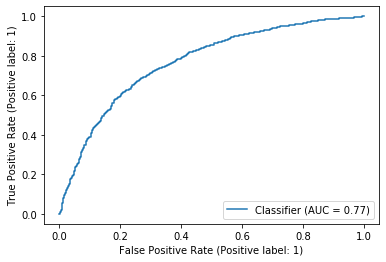

In [159]:
metrics.RocCurveDisplay.from_predictions(testY, gbc.predict_proba(testX)[:, 1])

In [32]:
ratiosCluster.columns[fi]

Index(['20TAH187mf', '20TAH187toke', '20TAC009kolt', '19TAH187mf',
       '16TAH187mf', '17TAC016kolt', '20TAC078kolt', '15TAC013kolt',
       '17TAH187mf', '18TAH187mf', '15TAH187mf', '19TAH187toke', '14TAH187mf',
       '14TAC013kolt', '15TAH187toke', '15TAC015kolt', '17TAH187toke',
       '17TAC018kolt', '19TAH004toke', '14TAH187toke', '18TAC008kolt',
       '16TAH044mf', '18TAH042mf', '20TAH042mf', '20TAC008kolt',
       '17TAH189toke', '14TAC014kolt', '19TAC014kolt', '19TAC013kolt',
       '17TAC015kolt', '20TAI019mf', '15TAH021kolt', '19TAH190mf',
       '16TAH088mf', '20TAI037mf', '16TAI036mf', '15TAC011kolt',
       '16TAB024kolt', '15TAB024mf', '16TAB024mf', '15TAH208toke',
       '16TAH054liab', '14TAC011kolt', '14TAB024kolt', '16TAH180liab',
       '19TAB024kolt', '14TAB024mf', '18TAH180liab', '16TAH005toke',
       '17TAI056mf'],
      dtype='object')

In [59]:
targetLabels.mean()

0.0

In [138]:
print(np.array(gradientResultSmoteN))

[0.78761062 0.78914176 0.79650846 0.7910407  0.79278294 0.78850889
 0.79040611 0.78852459 0.77943976]
